# Text Classification

# 1. Introduction

## 1.1. The task
The goal is to assign a label to some input text. This has applications in sentiment analysis, entity recognition and detecting language.

Text classification can be achieve using **representation models** i.e. encoder-only, or **generative models** i.e. decoder-only.

There are, of course, classical NLP approaches to this that do not rely on LLMs. For example, representing text using TF-IDF and training a logistic classifier on this.

One caveat to be aware of when using any pre-trained models is that we often don’t know the training data used; the weights are open-source but the training data isn’t.

This makes evaluation trickier, as we can’t be sure if our test data is truly *out-of-sample*.


# 2. Representation models

There are two approaches for using representation models as text classifiers:
1. Use a **pre-trained classification model** that was trained on a “similar enough” task
2. Use a pre-trained embedding model to get **embedding vectors** for your text. Then train a lightweight **classical ML classifier** like a logistic regression.

In both cases, we keep the pre-trained models *frozen* and only use their outputs.

The choice of model depends on: use case, language compatibility, architecture, size and performance. **Model selection** is a major contributor to the performance, and is an art form unto itself.

In this section, we’ll explore the different approaches on the example task of *movie review sentiment analysis*.


We can load the data set of movie reviews from Rotten Tomatoes that we will use in this example:

In [2]:
from datasets import load_dataset


data = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

As a bit of housekeeping, determine the right device to run models on depending on our hardware.

In [3]:
import torch


if torch.cuda.is_available():
    device = "cuda"
    device_map = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
    device_map=None
else:
    device = "cpu"
    device_map = "cpu"

## 2.1. Using a pre-trained classifier

We can load a pre-trained classification model from HuggingFace:


In [4]:
from transformers import pipeline 


model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest" 
pipe = pipeline(model=model_path, tokenizer=model_path, return_all_scores=True, device=device)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Then we use it to infer the sentiment of our test data:

In [5]:
import numpy as np 
from tqdm import tqdm 
from transformers.pipelines.pt_utils import KeyDataset 


# Run inference for each test instance
y_pred = [] 
for output in tqdm(pipe(KeyDataset(data["test"], "text")), total=len(data["test"])):
    negative_score = output[0]["score"] 
    positive_score = output[2]["score"] 
    assignment = np.argmax([negative_score, positive_score])
    y_pred.append(assignment)

100%|██████████| 1066/1066 [00:33<00:00, 32.03it/s]


We can then evaluate the performance by looking at classification metrics based on the confusion matrix:

In [10]:
from sklearn.metrics import classification_report 


performance = classification_report(
    data["test"]["label"],
    y_pred,
    target_names=["Negative Review", "Positive Review"]
)
print(performance)

                 precision    recall  f1-score   support

Negative Review       0.76      0.88      0.81       533
Positive Review       0.86      0.72      0.78       533

       accuracy                           0.80      1066
      macro avg       0.81      0.80      0.80      1066
   weighted avg       0.81      0.80      0.80      1066



This is a pretty good result considering we've just used a generic off-the-shelf model with no training and not specific to our domain! We get 80% accuracy and an F1 score of 0.81.

## 2.2. Using a pre-trained embedding model

This approach is helpful when we can not find a “similar enough” classification model that has been trained on a similar task.

We use an **embedding model** to generate embedding vectors for our text data. Think of this like the feature engineering step of a classical ML classification task.

We can then feed these embeddings / features to train a lightweight classifier. This can be any classifier of choice; there is nothing NLP-specific to the problem at this point.

We can load a pre-trained embedding model and use it to generate embeddings for our training and test data. This embedding model is kept frozen.

In [13]:
from sentence_transformers import SentenceTransformer 


model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
train_embeddings = model.encode(data["train"]["text"], show_progress_bar=True) 
test_embeddings = model.encode(data["test"]["text"], show_progress_bar=True)

Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Next we can use these embeddings to train a classifier. In this case, we just use a simple logistic regression, but this can be any classifier.

In [15]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, data["train"]["label"])

LogisticRegression(random_state=42)

Now we can evaluate the model as before:

In [17]:
y_pred = clf.predict(test_embeddings)
performance = classification_report(data["test"]["label"], y_pred, target_names=["Negative Review", "Positive Review"])

print(performance)

                 precision    recall  f1-score   support

Negative Review       0.85      0.86      0.85       533
Positive Review       0.86      0.85      0.85       533

       accuracy                           0.85      1066
      macro avg       0.85      0.85      0.85      1066
   weighted avg       0.85      0.85      0.85      1066



Even better! With a pre-trained embedding model and training our own lightweight classifier in a few seconds, we get improved accuracy of 85%.

## 2.3. Zero-shot classification using and embedding model

Getting labelled data is expensive and time-consuming.

We can use **zero-shot classification** in the absence of labels. This can be useful in cases where we want to assess the feasibility of a task as a first step to determine whether it’s worth the effort of collecting labelled data.

We do this by:

1. **Describe the label**, then create the embedding vector of this description. This acts as the baseline vector for the label. 
2. We can then **compare the embedding vector** of any text, using cosine similarity, to get a measure of how well our label matches our text. 


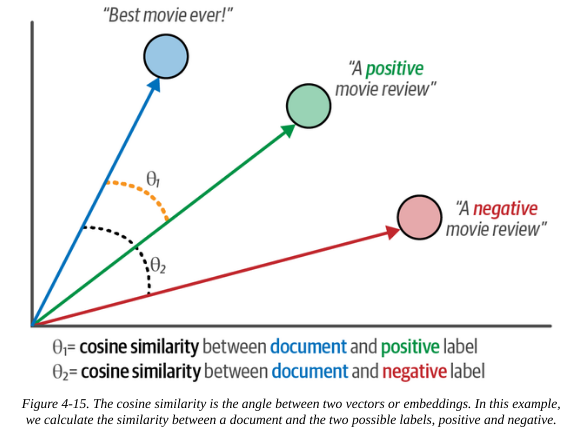


We create embedding vectors for our labels:


In [18]:
label_embeddings = model.encode(["A negative review", "A positive review"])

Then we can classify our text data by calculating the **cosine similarity** with each of our labels, and assigning the more similar label.


In [19]:
from sklearn.metrics.pairwise import cosine_similarity


sim_matrix = cosine_similarity(test_embeddings, label_embeddings)
y_pred = np.argmax(sim_matrix, axis=1)

Again, the model evaluation is the same:

In [20]:
performance = classification_report(data["test"]["label"], y_pred, target_names=["Negative Review", "Positive Review"])

print(performance)

                 precision    recall  f1-score   support

Negative Review       0.78      0.77      0.78       533
Positive Review       0.77      0.79      0.78       533

       accuracy                           0.78      1066
      macro avg       0.78      0.78      0.78      1066
   weighted avg       0.78      0.78      0.78      1066



The accuracy is 78%. Pretty good considering we have no labelled data and did no training!

# 3. Generative models

Generative models are **sequence-to-sequence** models. They might not have been trained on our specific use case, but they will have been trained on a wide variety of tasks and, with some judicious prompt engineering, we can coax it into performing classification.

We can use the ope-source encoder-decoder transformer model Flan for this.


In [21]:
pipe = pipeline("text2text-generation",  model="google/flan-t5-small", device=device)

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

We can then prompt it to classify each of our text examples:


In [22]:
prompt = "Is the following sentence positive or negative?"
data = data.map(lambda example: {"t5": prompt + example['text']})

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

The generative model outputs text, so we convert this to a classification integer.


In [23]:
y_pred = [] 
for output in tqdm(pipe(KeyDataset(data["test"], "t5")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)

  0%|          | 0/1066 [00:00<?, ?it/s]/Users/gurpreetjohl/miniconda3/envs/thellmbook/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1066/1066 [02:42<00:00,  6.54it/s]


The model evaluation is the same as always:

In [ ]:
performance = classification_report(data["test"]["label"], y_pred, target_names=["Negative Review", "Positive Review"])

print(performance)

                 precision    recall  f1-score   support

Negative Review       0.78      0.77      0.78       533
Positive Review       0.77      0.79      0.78       533

       accuracy                           0.78      1066
      macro avg       0.78      0.78      0.78      1066
   weighted avg       0.78      0.78      0.78      1066



An accuracy of 78%. Again, not too shabby considering we provided no labelled data and perfromed no training. The inference step takes longer than in other cases, so this is a consideration of whether a full-blown generative LLM is overkill for your specific use case.


We can do the same with closed-source models like ChatGPT by using the API. The premise is the same, you just need to pay $.


# References

- Chapter 4 of Hands-On Large Language Models by Jay Alammar & Marten Grootendoorst
- [Zero-shot classification tutorial from HuggingFace](https://huggingface.co/tasks/zero-shot-classification)